In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px

import networkx as nx
from collections import defaultdict, Counter
from multiprocessing import Pool, cpu_count
import pandas as pd
import numpy as np
import itertools


### Load data

In [2]:
# Read emotion data
df_emo = pd.read_csv(
    'NRC-Emotion-Lexicon-Wordlevel-v0.92.txt',
    sep='\t',
    header=None,
    names=['word', 'emotion', 'association'])

In [3]:
data = pd.read_csv('billboard_24years_lyrics_spotify_with_genres.csv')

# Remove rows containing NaN values in the 'genre'
data = data.dropna(subset=['genre'])

## Make data frame with all data
data_all = data.copy()

In [4]:
## Make data frame with single entry per songurl
data_single = data.copy()

# Songs that appear more than once in the dataset
duplicated_songurls = data[data.duplicated(subset=['songurl'], keep=False)]['songurl'].unique()

for songurl in duplicated_songurls[:10]:
    rows = data[data['songurl'] == songurl]
    
    # Combine rows by collecting band_singer and url as lists of unique elements
    combined_band_singer = list(rows['band_singer'].unique())
    combined_url = list(rows['url'].unique())

    danceability = rows['danceability'].mean()
    energy = rows['energy'].mean()
    key = rows['key'].mean()
    loudness = rows['loudness'].mean()
    mode = rows['mode'].mean()
    speechiness = rows['speechiness'].mean()
    acousticness = rows['acousticness'].mean()
    instrumentalness = rows['instrumentalness'].mean()
    liveness = rows['liveness'].mean()
    valence = rows['valence'].mean()
    tempo = rows['tempo'].mean()
    duration_ms = rows['duration_ms'].mean()


    # Create a new row with combined information
    new_row = rows.iloc[0].copy()
    new_row['band_singer'] = combined_band_singer
    new_row['url'] = combined_url
    new_row['danceability'] = danceability
    new_row['energy'] = energy
    new_row['key'] = key
    new_row['loudness'] = loudness
    new_row['mode'] = mode
    new_row['speechiness'] = speechiness
    new_row['acousticness'] = acousticness
    new_row['instrumentalness'] = instrumentalness
    new_row['liveness'] = liveness
    new_row['valence'] = valence
    new_row['tempo'] = tempo
    new_row['duration_ms'] = duration_ms

    # Drop the original rows and append the new combined row
    data_single = data_single[data_single['songurl'] != songurl]
    data_single.loc[len(data_single)] = new_row

# Sort data_single by ranking
data_single = data_single.sort_values(by='ranking').reset_index(drop=True)

### Basic statistics

In [5]:
## Basic statistics of genres
df_genres = data_single[data_single['genre'].apply(bool)].reset_index(drop=True)

df_genres['genre'] = (
    df_genres['genre']
      .astype(str)
      .apply(lambda x: [g.strip() for g in x.split(',')] if ',' in x else [x.strip()]))

Number of artists with genres: 3057
Average number of genres per artist: 2.1995420346745176
Total distinct genres: 327


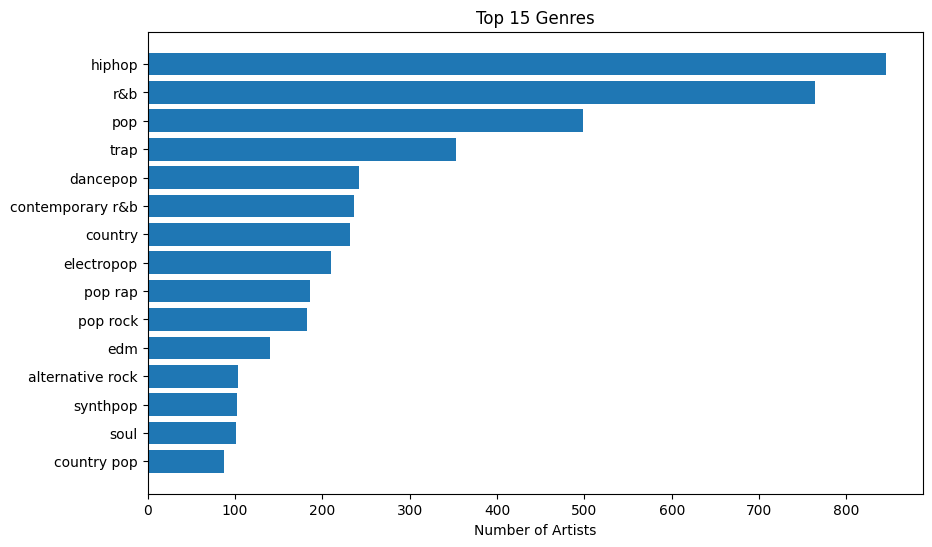

In [6]:
# --- Stats ---
num_artists_with_genres = len(df_genres)
avg_genres_per_artist = sum(len(genres) for genres in df_genres['genre']) / num_artists_with_genres
all_genres = [g for genres in df_genres['genre'] for g in genres]
num_distinct_genres = len(set(all_genres))
genre_counts = Counter(all_genres)

print("Number of artists with genres:", num_artists_with_genres)
print("Average number of genres per artist:", avg_genres_per_artist)
print("Total distinct genres:", num_distinct_genres)

# --- Histogram (top 15 genres) ---
if genre_counts:
    top = genre_counts.most_common(15)
    names, counts = zip(*top)
    plt.figure(figsize=(10,6))
    plt.barh(names[::-1], counts[::-1])
    plt.xlabel("Number of Artists")
    plt.title("Top 15 Genres")
    plt.show()

In [7]:
## Remove genres with less than 5 artists
filtered_genres = {genre for genre, count in genre_counts.items() if count >= 5}
df_genres['genre'] = df_genres['genre'].apply(lambda genres: [g for g in genres if g in filtered_genres])
df_genres = df_genres[df_genres['genre'].apply(bool)].reset_index(drop=True)

### Map emotions to genre 

In [8]:
## Expand dataframe so each genre has its own row
df_expanded = df_genres.explode('genre').reset_index(drop=True)

In [9]:
## Function to map song lyrics to emotions and count frequency

def map_song_to_emotions_count(song_lyrics: str, word_to_emotions: dict) -> dict:
    """
    Map words in a song's lyrics to emotions and count frequency.
    Returns a dictionary: emotion -> count of words
    """
    words = song_lyrics.lower().split()
    emotion_counts = Counter()
    for word in words:
        if word in word_to_emotions:
            for emotion in word_to_emotions[word]:
                emotion_counts[emotion] += 1
    return dict(emotion_counts)

# --- Main execution ---
if __name__ == "__main__":
    # Step 1: Filter emotions with association == 1
    df_emo_ones = df_emo[df_emo['association'] == 1]

    # Step 2: Pre-build word -> emotion mapping
    word_to_emotions = defaultdict(list)
    for _, row in df_emo_ones.iterrows():
        word_to_emotions[row['word']].append(row['emotion'])

    # Step 3: Prepare song lyrics list
    songs_lyrics = df_expanded['lyrics'].tolist()

    # Step 4: Define worker for multiprocessing
    def worker_map_song(lyrics):
        return map_song_to_emotions_count(lyrics, word_to_emotions)

    # Step 5: Sequential processing (no parallelism)
    emotion_dicts = [worker_map_song(lyrics) for lyrics in songs_lyrics]

    # Step 6: Convert list of dicts to DataFrame and combine
    df_emotions = pd.DataFrame(emotion_dicts).fillna(0)
    df_songs_with_emotions = pd.concat([df_expanded.reset_index(drop=True), df_emotions.reset_index(drop=True)], axis=1)



In [10]:
## Find average emotion per genre
emotion_cols = ['anticipation','fear','joy','positive','trust',
                'anger','disgust','negative','sadness','surprise']

df_emotions_by_genre = (
    df_songs_with_emotions
        .groupby('genre')[emotion_cols]
        .mean()
        .reset_index()
)

# # Most dominant emotion per genre
df_emotions_by_genre['dominant_emotion'] = df_emotions_by_genre[emotion_cols].idxmax(axis=1)

In [11]:
## Expand to have column with positive/negative and a column with dominant emotion
def dominant_sentiment(row):
    if row['positive'] >= row['negative']:
        return 'positive'
    else:
        return 'negative'
    
def dominant_emotion(row):
    sorted_emotions = row[emotion_cols].sort_values(ascending=False)
    if sorted_emotions.index[0] in ['positive', 'negative']:
        if sorted_emotions.index[1] in ['positive', 'negative']:
            return sorted_emotions.index[2]
        return sorted_emotions.index[1]
    else:
        return row[emotion_cols].idxmax()


df_emotions_by_genre['sentiment'] = df_emotions_by_genre.apply(dominant_sentiment, axis=1)
df_emotions_by_genre['dominant_emotion'] = df_emotions_by_genre.apply(dominant_emotion, axis=1)

### Graph representation

Network with genres as nodes and links being the connecting songs having the same genres

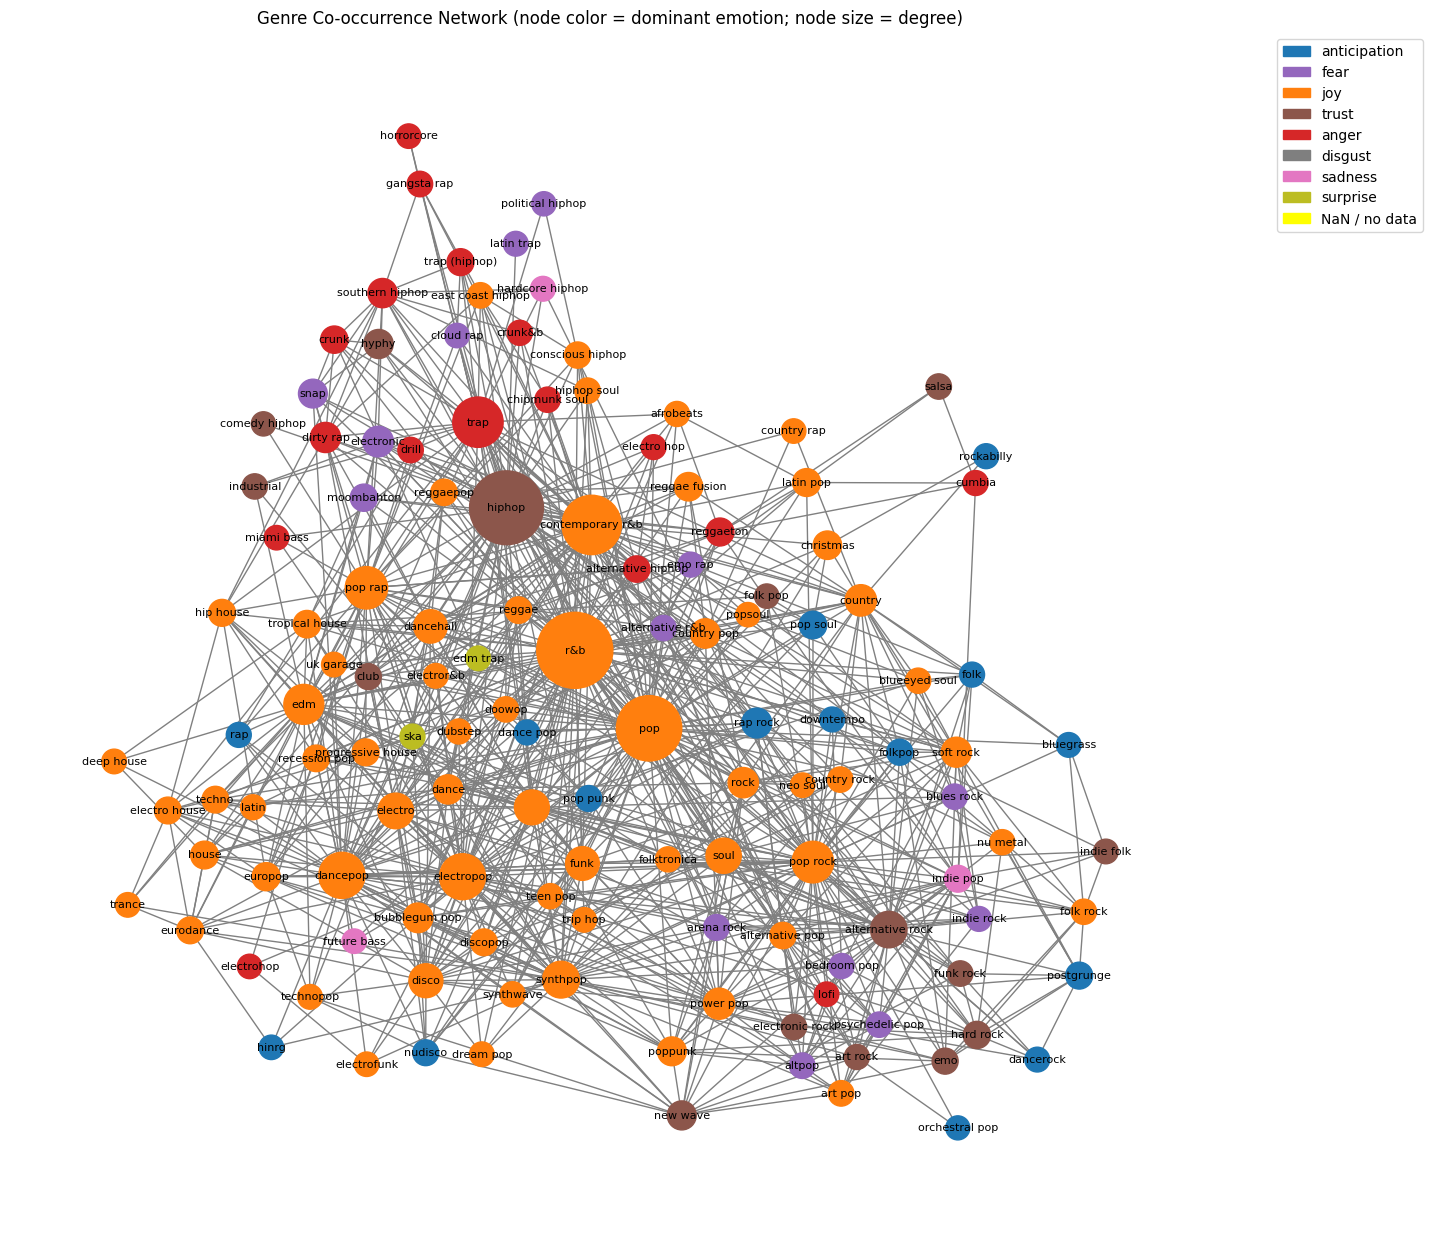

In [24]:
## Create graph with genres as nodes and links being the artist with both genres
G = nx.Graph()
for genres in df_genres['genre']:
    if len(genres) > 1:
        for genre1, genre2 in itertools.combinations(genres, 2):
            G.add_edge(genre1, genre2, weight=G.get_edge_data(genre1, genre2, {'weight': 0})['weight'] + 1)

G.remove_edges_from(nx.selfloop_edges(G))

# Map emotions to colors
emotion_color_map = {
    'anticipation': '#1f77b4', 
    'fear': '#9467bd', 
    'joy': '#ff7f0e',
    'trust': '#8c564b', 
    'anger': '#d62728', 
    'disgust': '#7f7f7f',
    'sadness': '#e377c2', 
    'surprise': '#bcbd22'
}

# Get node colors based on dominant emotion
node_colors = []
for node in G.nodes():
    dom = df_emotions_by_genre.loc[df_emotions_by_genre['genre'] == node, 'dominant_emotion']
    node_colors.append(emotion_color_map.get(dom.iloc[0], 'yellow') if not dom.empty and pd.notna(dom.iloc[0]) else 'yellow')

# Compute scaled node sizes from weighted degree
deg_vals = np.array([d for _, d in G.degree(weight='weight')])
node_sizes = (300 + (deg_vals - deg_vals.min()) / (deg_vals.max() - deg_vals.min() + 1e-10) * 2700).tolist()

# Draw the graph
plt.figure(figsize=(12, 12))
pos = nx.forceatlas2_layout(G, max_iter=1000, seed=42)
nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color=node_colors,
        font_size=8, edge_color="gray")

patches = [mpatches.Patch(color=c, label=e) for e, c in emotion_color_map.items()]
patches.append(mpatches.Patch(color='yellow', label='NaN / no data'))
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Genre Co-occurrence Network (node color = dominant emotion; node size = degree)")
plt.show()

## Dominant positive/negative/neutral

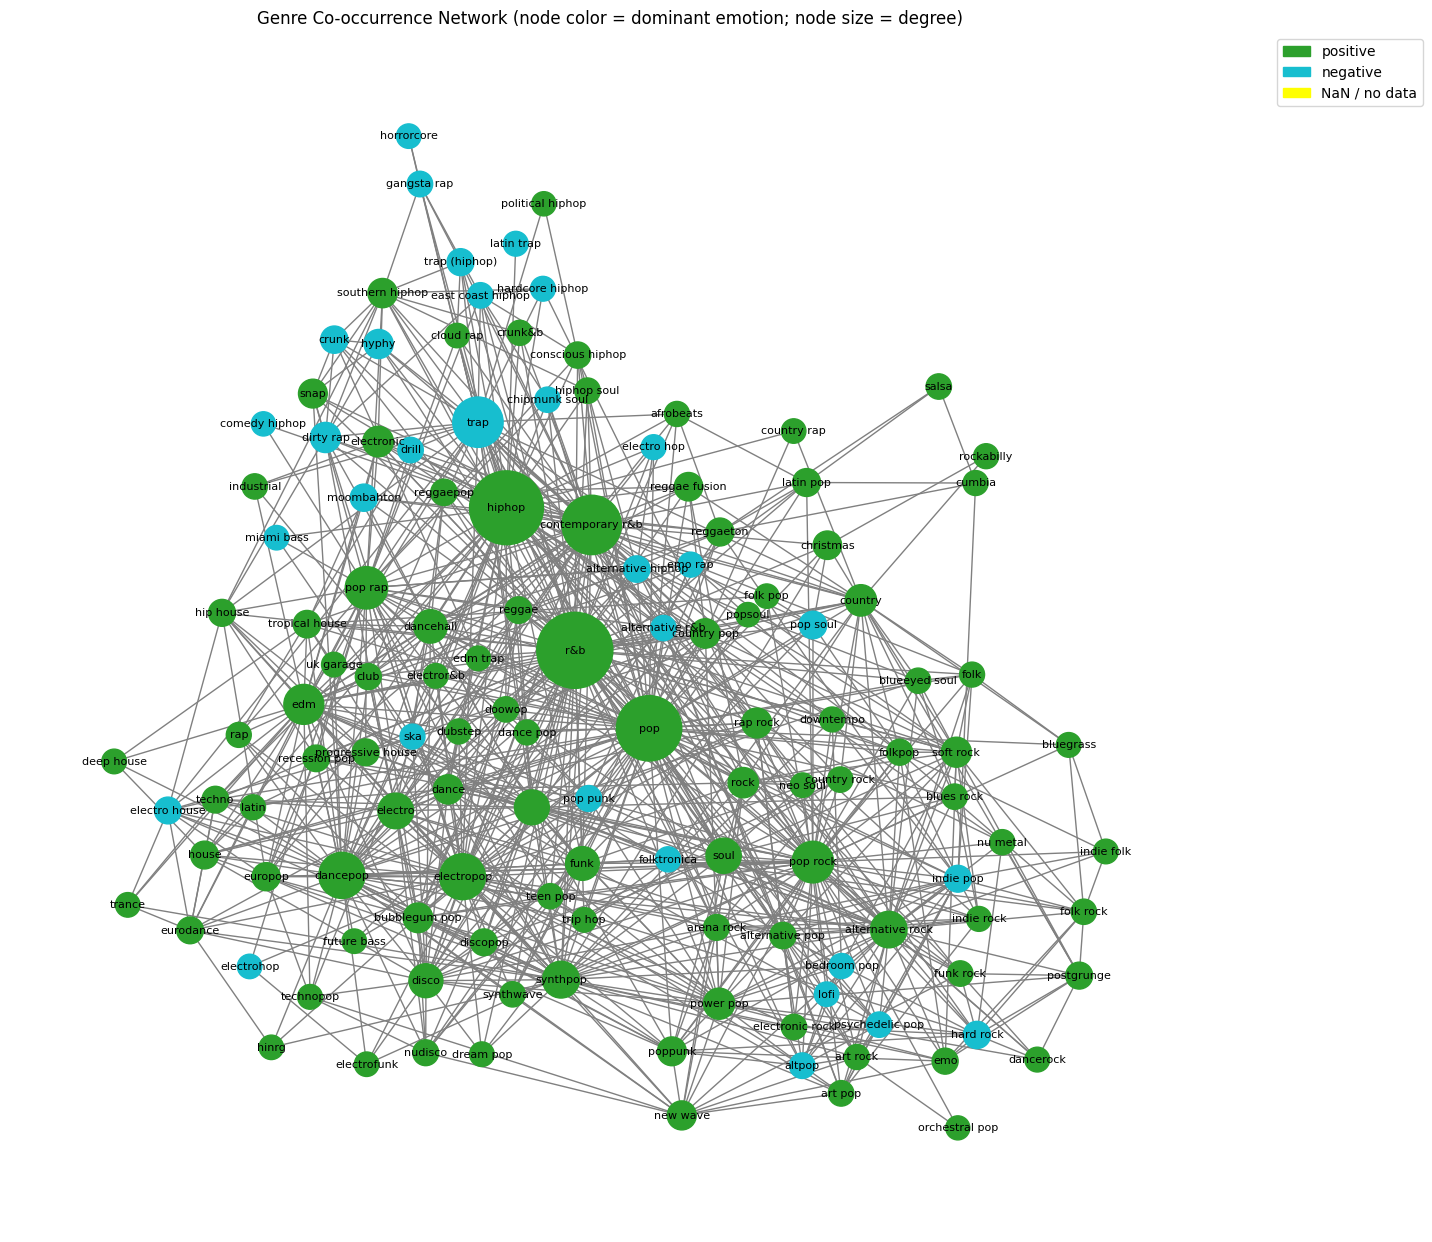

In [25]:
## Create graph with genres as nodes and links being the artist with both genres
G_ps = nx.Graph()
for genres in df_genres['genre']:
    if len(genres) > 1:
        for genre1, genre2 in itertools.combinations(genres, 2):
            G_ps.add_edge(genre1, genre2, weight=G_ps.get_edge_data(genre1, genre2, {'weight': 0})['weight'] + 1)

G_ps.remove_edges_from(nx.selfloop_edges(G_ps))

# Map emotions to colors
emotion_color_map = {
    'positive':     '#2ca02c',
    'negative':     '#17becf'
}

# Get node colors based on dominant emotion
node_colors = []
for node in G_ps.nodes():
    dom = df_emotions_by_genre.loc[df_emotions_by_genre['genre'] == node, 'sentiment']
    node_colors.append(emotion_color_map.get(dom.iloc[0], 'yellow') if not dom.empty and pd.notna(dom.iloc[0]) else 'yellow')

# Compute scaled node sizes from weighted degree
deg_vals = np.array([d for _, d in G_ps.degree(weight='weight')])
node_sizes = (300 + (deg_vals - deg_vals.min()) / (deg_vals.max() - deg_vals.min() + 1e-10) * 2700).tolist()

# Draw the graph
plt.figure(figsize=(12, 12))
pos = nx.forceatlas2_layout(G_ps, max_iter=1000, seed=42)
nx.draw(G_ps, pos, with_labels=True, node_size=node_sizes, node_color=node_colors,
        font_size=8, edge_color="gray")

patches = [mpatches.Patch(color=c, label=e) for e, c in emotion_color_map.items()]
patches.append(mpatches.Patch(color='yellow', label='NaN / no data'))
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Genre Co-occurrence Network (node color = dominant emotion; node size = degree)")
plt.show()

### What to include

__Betweenness centriality__ (fra social)

Measures how often a node lies on the shortest paths between others:

$$C_B(v) = \sum_{s \neq v \neq t} \frac{\sigma_{st}(v)}{\sigma_{st}}$$

Nodes with high betweenness act as 'bridges' between different groups or genres.

In [27]:
## Betweenness centrality
betweenness = nx.betweenness_centrality(G)
sorted_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)
print("Top 10 genres by betweenness centrality:")
for genre, centrality in sorted_betweenness[:10]:
    print(f"{genre}: {centrality:.4f}")

Top 10 genres by betweenness centrality:
r&b: 0.1515
hiphop: 0.1320
pop rock: 0.1109
pop: 0.1024
dancepop: 0.0661
trap: 0.0599
electropop: 0.0576
contemporary r&b: 0.0467
pop rap: 0.0429
synthpop: 0.0379


__Modularity__ (fra social)

For this we will use the measure **modularity** $M$ which is about looking into how the expected number of links between certain nodes (within a community) is compared to the actual number of links between those exact nodes. That is, if we for instance have a given degree sequence and the number of links between a chosen community of nodes is larger than expected, we would have positive modularity and hence a good "partitioning". 

In general, given a network with a community partioning, the higher the modularity, the better the partioning. On the other hand, the smaller the value of $M$ the worse the community structure. If we choose to maxmimize the modularity $M$ it would be equivalent to seeking the best community structure - the best partioning. 

(fra social)

We want to investigate different partionioning of communities using the genres to detect the partioning of the artists. Later on, we will use the Louvain-algorithm (LA) for the detection.

In order to evaulate the quality of the partioning, we use the modularity measure $M$ [1] (eq.12),

$$
M = \sum_{c=1}^{n_c} \left[ \frac{L_c}{L} - \left( \frac{k_c}{2L} \right)^2 \right]
$$

where $L$ is the number of links in the network, $n_c$ is the number of communities, $L_c$ is the number of links in the community $c$ and $k_c$ is the total degree of all nodes within the community. 

To investigate the quality of the community partioning when using the first genre listed in each infobox, we decide to construct these communitites and calculate the modularity.

In [ ]:
# Compute the best partition using Louvain Algorithm + Modularity
louvainC = nx.community.louvain_communities(G,seed=42) # NOTE I exercises bruges scikit pakke til Louvain

print(f"Detected {len(louvainC)} communities using Lovain algorithm.")

# Compute modularity
M_louvain = nx.community.modularity(G, louvainC)

L = G.number_of_edges()
M_LA = 0

for nodes in louvainC:
    subgraph = G.subgraph(nodes)
    Lc = subgraph.number_of_edges()
    kc = sum(dict(G.degree(nodes)).values())
    M_LA += (Lc / L) - (kc / (2*L))**2

print(f"Modularity computed from: {M_LA:.4f}")

Detected 6 communities using Lovain algorithm.
Modularity computed from: 0.2642


In [33]:
## Print the communities
for i, community in enumerate(louvainC):
    print(f"Community {i+1}: {community}")
    # Mean emotion per community
    comm_emotions = df_emotions_by_genre[df_emotions_by_genre['genre'].isin(community)]
    mean_emotions = comm_emotions[emotion_cols].mean().sort_values(ascending=False)
    print("Three most common emotions in community:")
    print(mean_emotions.head(3))
    print('\n')

Community 1: {'folk pop', 'pop soul', 'christmas', 'rockabilly'}
Three most common emotions in community:
positive        12.352139
anticipation     8.378610
joy              7.682888
dtype: float64


Community 2: {'dance', 'dancehall', 'reggaepop', 'reggae fusion', 'reggaeton', 'salsa', 'cumbia', 'miami bass', 'latin pop'}
Three most common emotions in community:
positive    13.003680
negative     9.649062
joy          8.114093
dtype: float64


Community 3: {'power pop', 'hard rock', 'folkpop', 'psychedelic pop', 'funk rock', 'folk', 'folk rock', 'emo', 'bluegrass', 'bedroom pop', 'cloud rap', 'alternative r&b', 'soft rock', 'country pop', 'country', 'downtempo', 'country rock', 'rock', 'country rap', 'art rock', 'arena rock', 'lofi', 'postgrunge', 'pop rock', 'alternative rock', 'rap rock', 'alternative hiphop', 'orchestral pop', 'new wave', 'art pop', 'nu metal', 'altpop', 'blueeyed soul', 'indie rock', 'indie folk', 'indie pop', 'emo rap', 'blues rock', 'alternative pop', 'electron

Ser at positive og negative fylder meget. Derefter har community 2, 3, 5, 6 alle 'joy' som den emotion der ellers dominerer, hvor at anticipation dominerer i community 1 og anger i community 4. _Hvorfor?_ 